# Binarization of Badly Illuminated Document Images through Shading Estimation and Compensation

In [12]:
import sys

import cv2
print("OpenCV version:", cv2.__version__)
import matplotlib.pyplot as plt
import matplotlib
print("Matplotlib.Pyplot", matplotlib.__version__)
import numpy as np
print("Numpy version:", np.__version__)

import math
from scipy import signal
import scipy

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# 用于在 Jupyter Notebook 内部显示图片
%matplotlib inline    

def readRGB(filename: str):
    # 读入一个 RGB 图像
    blue, green, red = cv2.split( cv2.imread(filename) )
    return cv2.merge( (red, green, blue) )

def readGRAY(filename: str):
    # 读入一个单通道灰度图
    return cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

def show(pic_1, pic_2=None, pic_3=None, msg_1="Ori", msg_2="PIC_2", msg_3="PIC_3"):
    # 未优化
    # 传入图片均为 灰度图像
    if pic_3 is None:
        if pic_2 is None:
            plt.figure(figsize=(10, 10))
            plt.imshow(pic_1, cmap='gray')
            plt.title(msg_1)
            plt.xticks([])
            plt.yticks([])
            return
        else:
            plt.figure(figsize=(10, 10))
            plt.subplot(121)
            plt.imshow(pic_1, cmap='gray')
            plt.title(msg_1)
            plt.xticks([])
            plt.yticks([])
            plt.subplot(122)
            plt.imshow(pic_2, cmap='gray')
            plt.title(msg_2)
            plt.xticks([])
            plt.yticks([])
    else:
        plt.figure(figsize=(10, 10))
        plt.subplot(131)
        plt.imshow(pic_1, cmap='gray')
        plt.title(msg_1)
        plt.xticks([])
        plt.yticks([])
        plt.subplot(132)
        plt.imshow(pic_2, cmap='gray')
        plt.title(msg_2)
        plt.xticks([])
        plt.yticks([])
        plt.subplot(133)
        plt.imshow(pic_3, cmap='gray')
        plt.title(msg_3)
        plt.xticks([])
        plt.yticks([])
    plt.savefig('CV_TEST.png', dpi=500)

OpenCV version: 4.5.5
Matplotlib.Pyplot 3.5.1
Numpy version: 1.21.2


> 摘要：这篇文章介绍了一种二值化图片的方法：将文字从恶劣光照文档中提取出来；
- 文档通常在一个平整或光滑的表面；
- 背景颜色通常是均匀的；
我们可以使用平滑多项式曲面对照明不良的文档图像进行二值化，从而估计着色变化，并根据古籍的颜色不长

# Figure 1

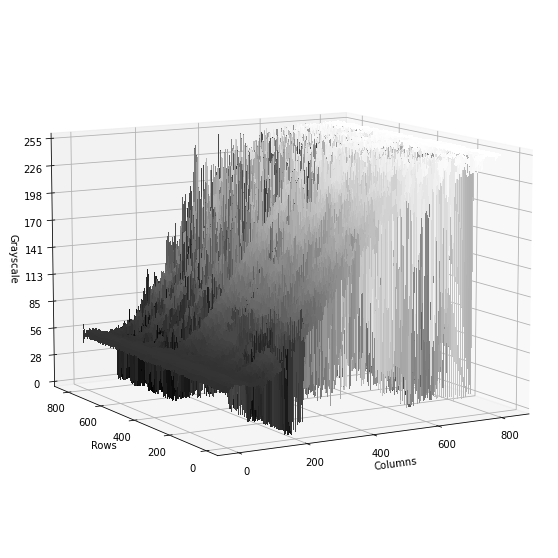

In [13]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import cv2

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

# Make data.
X = np.arange(0, 829, 1)
Y = np.arange(0, 829, 1)
X, Y = np.meshgrid(X, Y)
img = cv2.resize(readGRAY('data/doc_1.png'), (829, 829))

surf = ax.plot_surface(X, Y, img, 
                    
                       cmap=cm.gist_gray,
                       rstride = 10, cstride = 10,
                       linewidth=0, 
                       antialiased=False
                      )

# Customize the z axis.
ax.set_zlim(0, 255)  # z轴的取值范围
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%d'))

ax.elev = 10
ax.azim = 240

ax.set_zlabel("Grayscale")
ax.set_xlabel("Columns")
ax.set_ylabel("Rows")

plt.show()

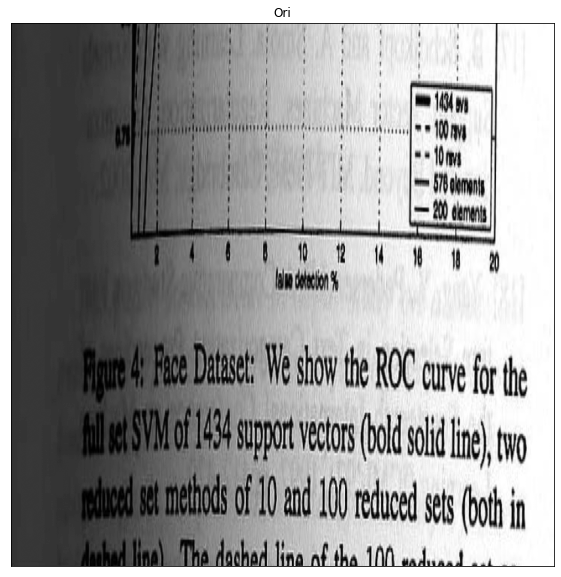

In [14]:
show(img)

In [15]:
def sgolay2d ( z, window_size, order, derivative=None):
    """
    """
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0

    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')

    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2

    # exponents of the polynomial.
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ...
    # this line gives a list of two item tuple. Each tuple contains
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]

    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])

    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band )
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z

    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band )

    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band )
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band )

    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -c, mode='valid')
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid')
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid'), scipy.signal.fftconvolve(Z, -c, mode='valid')

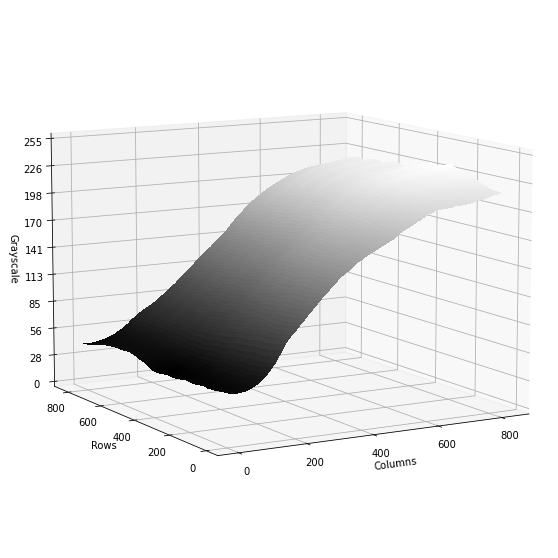

In [16]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(projection='3d')
# Make data.
X = np.arange(0, 829, 1)
Y = np.arange(0, 829, 1)
X, Y = np.meshgrid(X, Y)
img = cv2.resize(readGRAY('data/doc_1.png'), (829, 829))

img_f = sgolay2d( img, window_size=829, order=3)

surf = ax.plot_surface(X, Y, img_f,
                       #cmap=cm.coolwarm,
                       cmap=cm.gist_gray,
                       rstride = 10, cstride = 10,
                       linewidth=0,
                       antialiased=False
                      )

# Customize the z axis.
ax.set_zlim(0, 255)  # z轴的取值范围
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%d'))

ax.elev = 10
ax.azim = 240

ax.set_zlabel("Grayscale")
ax.set_xlabel("Columns")
ax.set_ylabel("Rows")

plt.show()

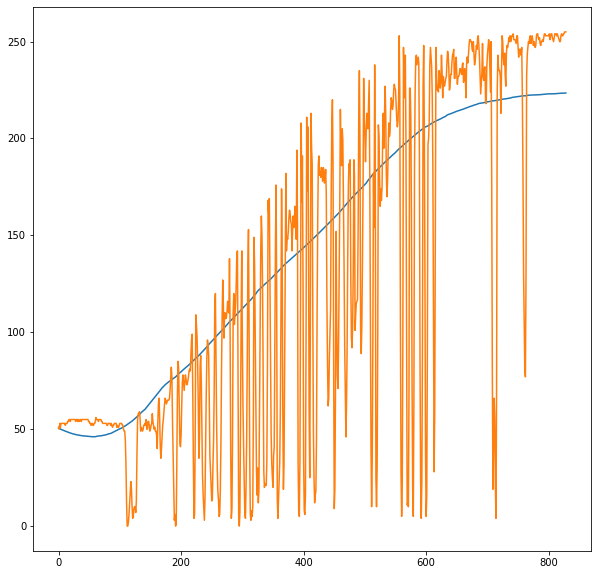

In [17]:
pos = 511
plt.figure(figsize=(10, 10))
plt.plot(img_f[:][pos])
plt.plot(img[:][pos])

# Surface 2

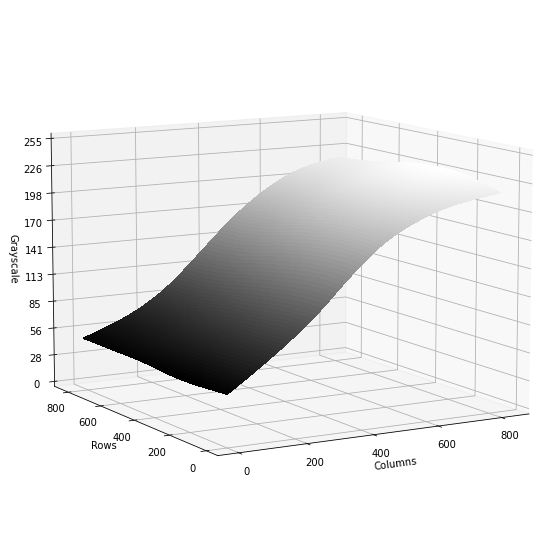

In [18]:

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(projection='3d')
# Make data.
X = np.arange(0, 829, 1)
Y = np.arange(0, 829, 1)
X, Y = np.meshgrid(X, Y)

img_ff = sgolay2d( img_f, window_size=829, order=3)

surf = ax.plot_surface(X, Y, img_ff,
                       #cmap=cm.coolwarm,
                       cmap=cm.gist_gray,
                       rstride = 10, cstride = 10,
                       linewidth=0,
                       antialiased=False
                      )

# Customize the z axis.
ax.set_zlim(0, 255)  # z轴的取值范围
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%d'))

ax.elev = 10
ax.azim = 240

ax.set_zlabel("Grayscale")
ax.set_xlabel("Columns")
ax.set_ylabel("Rows")

plt.show()

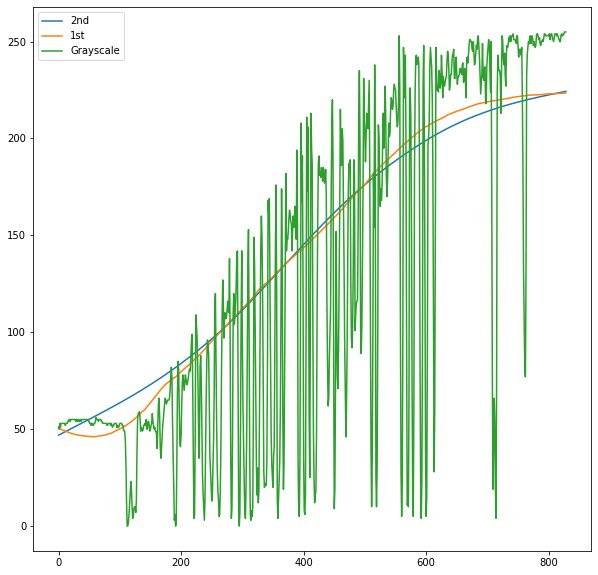

In [19]:
pos = 511
plt.figure(figsize=(10, 10))
plt.plot(img_ff[:][pos], label="2nd")
plt.plot(img_f[:][pos], label="1st")
plt.plot(img[:][pos], label="Grayscale")
plt.legend()

The K is :  54.91061069975207


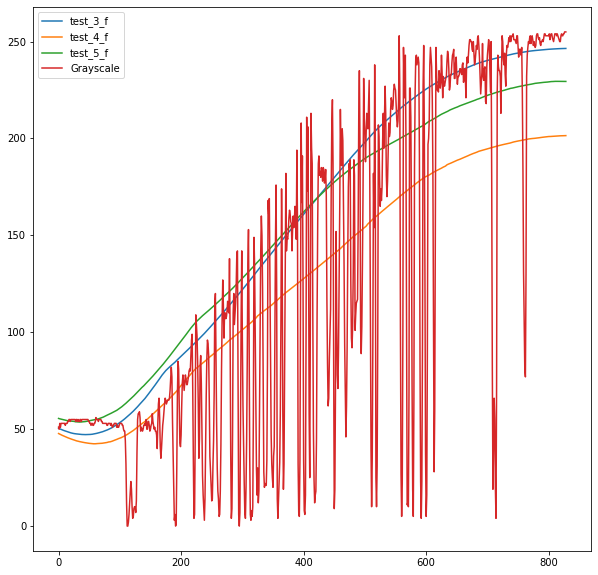

In [20]:
row, col = img.shape
sum = 0
count = 0
for i in range(row):
    for j in range(col):
        temp = img_f[i][j] - img[i][j]
        if temp > 0:
            sum += temp
            count += 1
K = sum / count
print("The K is : ", K)

test_1 = img.copy() # None background turn to 255
test_2 = img.copy() # None background turn to 0

for i in range(row):
    for j in range(col):
        if img_f[i][j] - img[i][j] < K:
            test_1[i][j] = 255
            test_2[i][j] = 0
            
test_1_f = sgolay2d( test_1, window_size=829, order=3)
test_2_f = sgolay2d( test_2, window_size=829, order=3)

test_3 = img.copy()

for i in range(row):
    for j in range(col):
        if img_f[i][j] - img[i][j] > K:
            test_3[i][j] = img_f[i][j]
        else:
            test_3[i][j] = img[i][j]

test_3_f = sgolay2d( test_3, window_size=829, order=3)

test_4 = img.copy()  
for i in range(row):
    for j in range(col):
        if img_f[i][j] - img[i][j] < K:
            test_4[i][j] = img_f[i][j]
        else:
            test_4[i][j] = img[i][j]   
test_4_f = sgolay2d( test_4, window_size=829, order=3)

test_5 = img.copy()  
for i in range(row):
    for j in range(col):
        if img_f[i][j] - img[i][j] < K:
            test_5[i][j] = img_f[i][j]
        else:
            test_5[i][j] = -1   
test_5_f = sgolay2d( test_5, window_size=829, order=3)
            
pos = 511
plt.figure(figsize=(10, 10))
#plt.plot(img_ff[:][pos], label="2nd")
#plt.plot(img_f[:][pos], label="1st")

#plt.plot(test_1_f[:][pos], label="test_1_f")
#plt.plot(test_2_f[:][pos], label="test_2_f")
plt.plot(test_3_f[:][pos], label="test_3_f")
plt.plot(test_4_f[:][pos], label="test_4_f")
plt.plot(test_5_f[:][pos], label="test_5_f")

plt.plot(img[:][pos], label="Grayscale")
plt.legend()

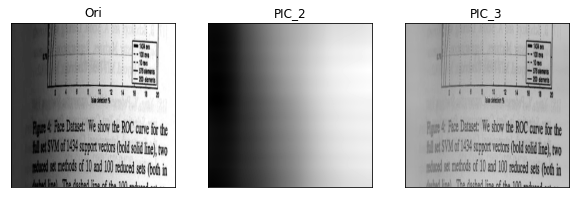

In [21]:
show(img, img_f, img - img_f)

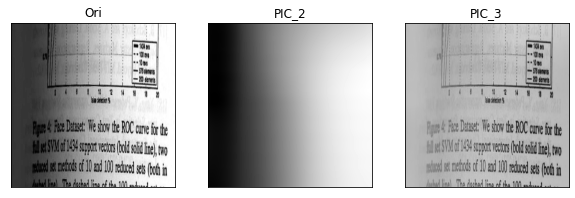

In [22]:
show(img, test_3_f, img - test_3_f)

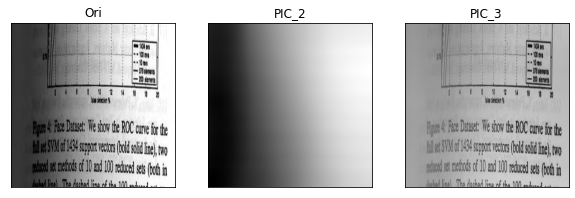

In [23]:
show(img, test_4_f, img - test_4_f)

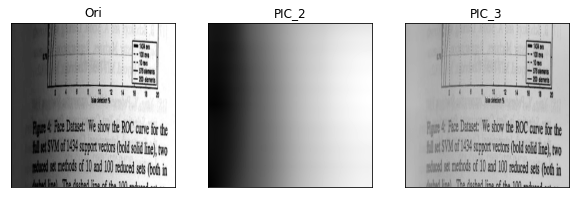

In [24]:
show(img, test_5_f, img - test_5_f)

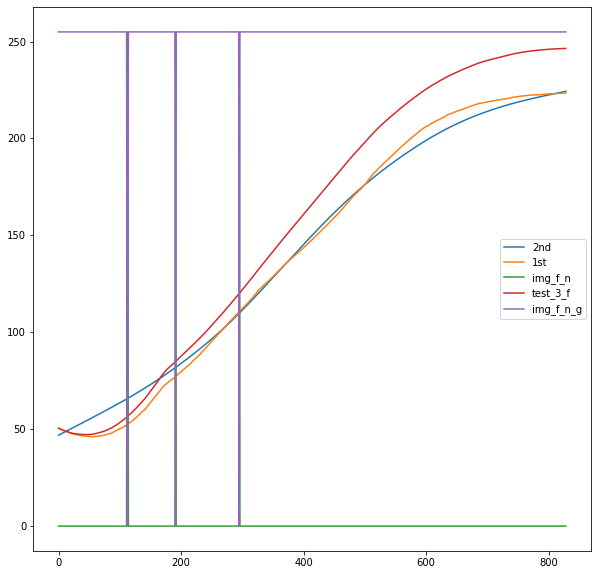

In [25]:
img_f_n = img.copy()
for i in range(row):
    for j in range(col):
        if test_3_f[i][j] > 0:
            img_f_n[i][j] = (img[i][j] - test_3_f[i][j]) / test_3_f[i][j]
        else:
            img_f_n[i][j] = -1

img_f_n_g = 255 * (img_f_n + 1)
            
pos = 511
plt.figure(figsize=(10, 10))
plt.plot(img_ff[:][pos], label="2nd")
plt.plot(img_f[:][pos], label="1st")

plt.plot(img_f_n[:][pos], label="img_f_n")
plt.plot(test_3_f[:][pos], label="test_3_f")
plt.plot(img_f_n_g[:][pos], label="img_f_n_g")

plt.legend()

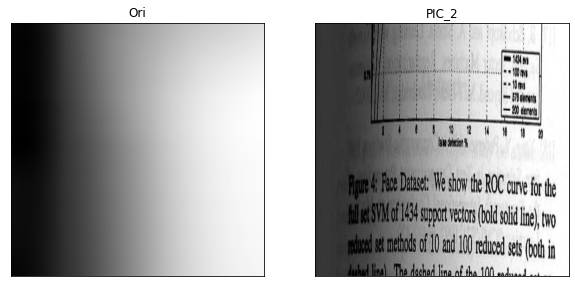

In [26]:
show(test_3_f, img)

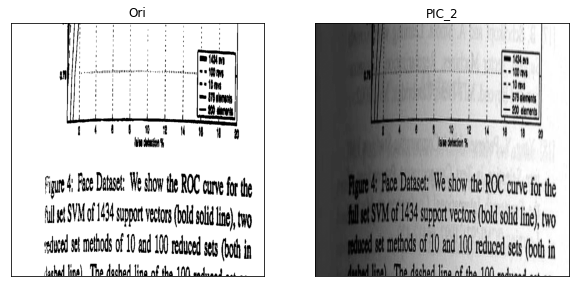

In [27]:
new = img.copy()
for i in range(row):
    for j in range(col):
        if test_3_f[i][j] - img[i][j] > K:
            new[i][j] = 0
        else:
            new[i][j] = 255
show(new, img)

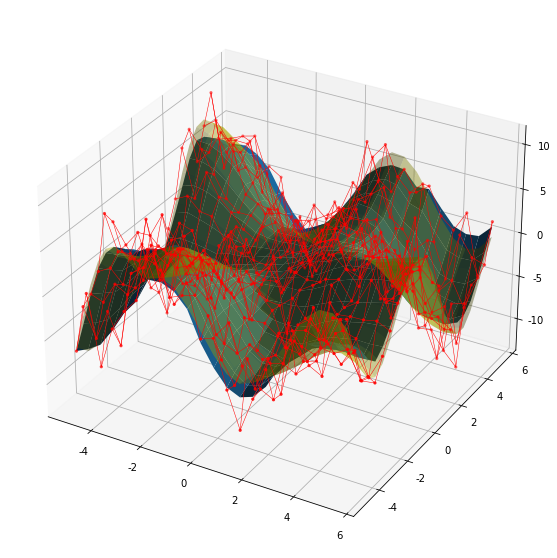

In [28]:
np.random.seed(12345)

x, y = np.mgrid[-5:6:.5, -5:6:.5]
z = y * np.sin(x) + x * np.cos(y)
zn = z + np.random.randn(*x.shape) * 2.

#zs = sgolay2.SGolayFilter2(window_size=9, poly_order=3)(zn)
win = zn.shape[0] -1
zs = sgolay2d(zn, 9, 3)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(x, y, zn, linewidths=0.5, color='r')
ax.scatter(x, y, zn, s=5, c='r')

ax.plot_surface(x, y, zs, linewidth=0)
ax.plot_surface(x, y, z, color='y', linewidth=0, alpha=0.4)

plt.show()

In [ ]:
rand = np.random.randn(9, 9)
Mat = np.arange(1, 82, 1).reshape(9, 9) + rand


Mat_s = sgolay2d(Mat, 7, 3)
print(Mat, Mat.shape,'\n\n', Mat_s, Mat_s.shape)
show(Mat, Mat_s)

[[ 1.08380307  0.1276611   2.03720898  4.08006683  5.12872644  5.52087966
   6.3597195   8.7459738   8.37745294]
 [10.93628932 11.75001838 11.94328497 15.30067451 14.56949747 16.48940968
  17.26425028 16.23816279 17.6683831 ]
 [17.24868457 20.62889411 21.28250186 20.66186057 22.49939315 24.12164503
  26.70832347 25.02900055 26.38066766]
 [27.27329187 30.22165542 30.50369929 29.61212592 32.20485142 33.60370522
  34.54568031 35.23547702 36.11183499]
 [35.74849625 35.0506565  39.63463416 40.12415702 42.29762249 40.31306659
  44.08953905 46.06088174 44.75876467]
 [45.05212782 47.67629403 47.34664384 48.3477047  50.5288276  51.35779325
  52.18864936 53.86941688 53.94933255]
 [54.28363543 55.89674128 55.85896342 57.4992231  58.61069863 59.52614947
  61.1286643  62.15369431 63.44479006]
 [64.12853167 65.25252987 65.05936134 68.00214545 67.47458502 68.11259906
  71.8313136  70.07697067 72.70053769]
 [72.1078488  76.30074    74.1822347  76.51375963 77.62358694 79.48920593
  80.94047867 80.54323